In [60]:

import tensorflow as tf
import math
import numpy as np
import read_data
from sklearn.model_selection import train_test_split
import cv2 as cv
import matplotlib.pyplot as plt
import dlib

In [61]:
class FARE_Net:
    def __angular_err(self, v1, v2):
        v1xv2 = tf.reduce_sum(v1*v2,1)
        v1_len = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(v1), 1)),dtype=tf.float32)
        v2_len = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(v2), 1)),dtype=tf.float32)
        
        val = tf.minimum( v1xv2/((v1_len* v2_len ) + 1e-10), 0.999999)
    
        degree = tf.acos(val)
        return degree * 180/ math.pi
    
    def __init__(self, far_net_model_path, e_net_model_path):
        self.far_net = tf.keras.models.load_model(far_net_model_path)
        self.e_net = tf.keras.models.load_model(e_net_model_path)
        
    def predict(self, data) :
        gaze_directions = self.far_net(data)
        probabilities = self.e_net(data[0:2])
        
        choosed_gaze = []
        choosed = []
        
        for i, prob in enumerate(probabilities):
            if prob[0] <= prob[1]:
                choosed_gaze.append(gaze_directions[i][:3])
                choosed.append("Left")
            else :
                choosed_gaze.append(gaze_directions[i][3:])
                choosed.append("Right")
        
        return choosed_gaze, choosed
    
    def validate(self, data, labels):
        print("Validating...")
        gazes, chooseds = self.predict(data=data)
        
        new_labels = []
        
        for choosed, label in zip(chooseds, labels):
            
            if choosed == "Left" :
                new_labels.append(label[:3])
            else :
                new_labels.append(label[3:])
                
                
        angular_errors = self.__angular_err(gazes, tf.cast(np.array(new_labels, dtype=float), dtype=tf.float32))
            
        print(f"Mean Angular Error => {tf.reduce_mean(angular_errors)}")
            

In [62]:

# Define a function to extract the 6 key points
def get_facial_landmarks(image):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor('Face Landmarks Predictor.dat')
  gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  faces = detector(gray)
  
  face = faces[0]
  
  landmarks = predictor(gray, face)
  
  points = []
  
  for i in  [36, 39, 42, 45, 48, 54] :
    points.append(landmarks.part(i).x)
    points.append(landmarks.part(i).y)
  
  return points

def get_face_image(image, landmarks, margin=40):
  
  # Extract facial landmark coordinates
  x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 = landmarks
  
  # Calculate bounding box coordinates with margin clamping
  left = max(0, min(x1, x2, x3, x4, x5, x6) - margin)
  top = max(0, min(y1, y2, y3, y4, y5, y6) - margin)
  right = min(image.shape[1], max(x1, x2, x3, x4, x5, x6) + margin)
  bottom = min(image.shape[0], max(y1, y2, y3, y4, y5, y6) + margin)
  
  # Crop the image based on clamped bounding box
  cropped_image = image[top:bottom, left:right]
  
  # Resize the image to 224x224 pixels (optional)
  resized_image = cv.resize(cropped_image, (224, 224))
  
  return resized_image


def calculate_face_center(facial_landmarks):

  x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 = facial_landmarks
  
  x_center = sum([x1, x2, x3, x4, x5, x6]) / 6
  y_center = sum([y1, y2, y3, y4, y5, y6]) / 6
  
  return int(x_center), int(y_center)
  
def crop_and_resize_eye(image, eye_points : list):
    
    x_diff = abs(eye_points[0] - eye_points[2])
    y_diff = abs(eye_points[1] - eye_points[3])
    
    x_margin = ((60-x_diff) // 2) + 2
    y_margin = ((36-y_diff) // 2) + 1
    
    # Calculate bounding box for eye region
    min_x = min([eye_points[0],eye_points[2]]) - x_margin
    max_x = max([eye_points[0],eye_points[2]]) + x_margin
    min_y = min([eye_points[1],eye_points[3]]) - y_margin
    max_y = max([eye_points[1],eye_points[3]]) + y_margin

    # Extract eye region
    eye_image = image[min_y:max_y, min_x:max_x]

    # Resize eye image to 36x60
    eye_image = cv.resize(eye_image, (60, 36))

    return eye_image
  
def orthographic_projection(vector):
  # Assuming the vector is of the form (x, y, z)
  x, y, z = vector
  # Project onto the XY plane by dropping the z-coordinate
  return np.array([x, y])


In [63]:
def visualize_gaze(image):
    raw_face_img = image

    raw_img_landmarks = get_facial_landmarks(raw_face_img)
    # center_x, center_y = calculate_face_center(raw_img_landmarks)

    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 = raw_img_landmarks
    
    r_center_x = (x1 + x2) // 2
    r_center_y = (y1 + y2) // 2
    
    l_center_x = (x3 + x4) // 2
    l_center_y = (y3 + y4) // 2
    

    r_eye_img = crop_and_resize_eye(raw_face_img,[x1, y1, x2, y2])
    r_eye_img = cv.cvtColor(r_eye_img, cv.COLOR_RGB2GRAY)
    r_eye_img = r_eye_img / 255.0

    l_eye_img = crop_and_resize_eye(raw_face_img,[x3, y3, x4, y4])
    l_eye_img = cv.cvtColor(l_eye_img, cv.COLOR_RGB2GRAY)
    l_eye_img = l_eye_img / 255.0
    
    face_img = get_face_image(raw_face_img,raw_img_landmarks)
    face_img = face_img / 255.0

    # plt.subplot(2,3,1)
    # plt.imshow(r_eye_img, cmap="gray")
    # plt.subplot(2,3,2)
    # plt.imshow(l_eye_img, cmap="gray")
    # plt.subplot(2,3,3)
    # plt.imshow(face_img, cmap="gray")
    
    model_path = "log/enhanced2/1"

    fare_net = FARE_Net(far_net_model_path=f"{model_path}/far_net_model.keras", e_net_model_path=f"{model_path}/e_net_model.keras")

    gaze, choosed = fare_net.predict([np.array([l_eye_img]), np.array([r_eye_img]), np.array([face_img])])

    if choosed[0] == "Left" :
        center_x =  l_center_x
        center_y = l_center_y
    else :
        center_x =  r_center_x
        center_y = r_center_y
        
        
    
    # Normalize the vector
    magnitude = np.linalg.norm(gaze[0])
    normalized_vector = gaze[0] / magnitude

    # Define a scaling factor to control the length of the projected vector
    scaling_factor = 200  # Adjust this value as needed

    # Project the 3D vector onto 2D plane
    # For simplicity, we ignore the z-component as the projection
    # onto the image plane (x, y) is typically the perspective we want
    end_x = center_x - normalized_vector[0] * scaling_factor
    end_y = center_y + normalized_vector[1] * scaling_factor  # Subtract to invert y-axis (image coordinates)

    rgb_img = cv.cvtColor(raw_face_img,cv.COLOR_BGR2RGB)

    plt.figure(figsize=(8,6))
    plt.imshow(rgb_img)
    plt.plot([end_x,center_x], [end_y,center_y], 'g-', linewidth=2)  # Draw the gaze vector
    # plt.scatter(center_x, center_y, color='red',linewidths=1)
    plt.title(f'Gaze Direction Visualization - {choosed[0]} Eye')
    plt.show()


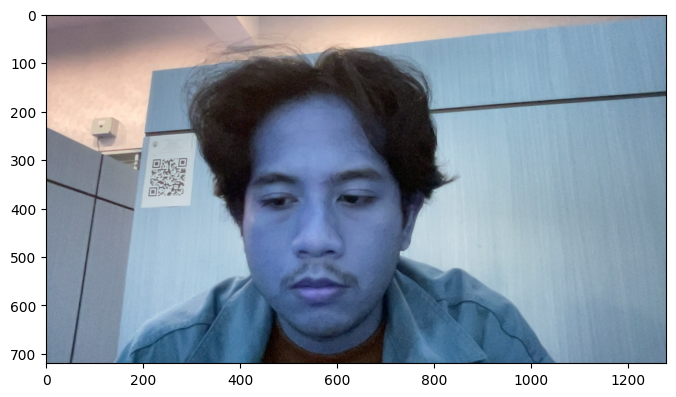

In [64]:

# 1.creating a video object
video = cv.VideoCapture(0) 
# 2. Variable
a = 0
# 3. While loop
while True:
    a = a + 1
    # 4.Create a frame object
    check, frame = video.read()
    # Converting to grayscale
    #gray = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
    # 5.show the frame!
    # cv.imshow("Capturing",frame)
    # 6.for playing 
    key = cv.waitKey(1)
    if a == 30 :
        break   

plt.figure(figsize=(8,6))
plt.imshow(frame)
# 7. image saving
# showPic = cv.imwrite("filename.jpg",frame)
# print(showPic)
# 8. shutdown the camera
video.release()
cv.destroyAllWindows() 

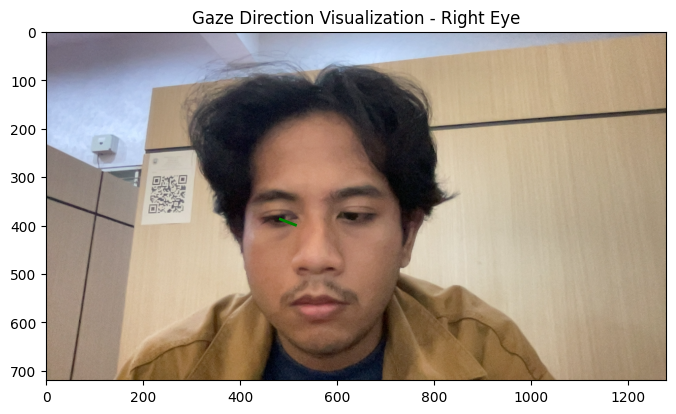

In [65]:
# frame = cv.imread("dataset/MPIIFaceGaze/p14/day01/0018.jpg")
visualize_gaze(frame)